In [85]:
import mdshare
import pyemma
#Standard imports
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
})
import tqdm
import sys
sys.path.append("../../")
from kooplearn.estimators import ReducedRank
from kooplearn.kernels import RBF, Linear

In [17]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

In [18]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = np.concatenate(pyemma.coordinates.load(files, features=torsions_feat))

Obtaining file info:   0%|          | 0/25 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/25 [00:00<?, ?it/s]

In [109]:
kernel = RBF(length_scale=1.0)
params = {
    'kernel': kernel,
    'backend': 'numpy',
    'rank': 5,
    'svd_solver': 'arnoldi',
    'n_oversamples': 3,
    'iterated_power': 1
}
stride = 20 #We subsample the data to reduce the number of samples
X_train, Y_train = torsions_data[::stride][:-1], torsions_data[::stride][1:]
est = ReducedRank(**params, tikhonov_reg = 1e-7)
est.fit(X_train, Y_train)

ReducedRank(kernel=<kooplearn.kernels.RBF object at 0x7f8acce197f0>,
            n_oversamples=3, svd_solver='arnoldi', tikhonov_reg=1e-07)

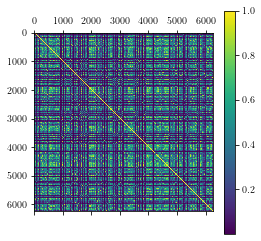

In [110]:
plt.matshow(est.K_X_)
plt.colorbar()

In [104]:
eigvals, left_funs, right_funs = est.eig(left=True, right=True)

In [105]:
eigvals

array([0.95462948+0.j, 0.24261639+0.j, 0.14526067+0.j, 0.01530618+0.j,
       0.00875571+0.j])

In [106]:
eval_rf = right_funs(torsions_data)
eval_lf = left_funs(torsions_data)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

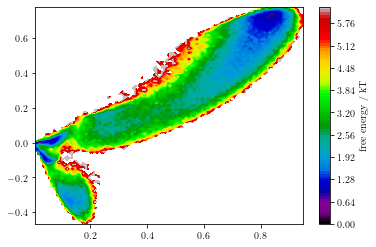

In [108]:
pyemma.plots.plot_free_energy(eval_lf[:,0].real, eval_lf[:,1].real)